In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


In [ ]:
from numbalsoda import lsoda_sig, lsoda
import numba as nb

@nb.cfunc(lsoda_sig)
def rhs(t, q, dq, p):
    '''
    q: state variable
    q[0] : x , q[1] : y , q[2] : z
    q[3] : vx , q[4] : vy , q[5] : vz
    dq: derivative of q
    p: parameters
    '''
    a, alpha, R, gravity, Fr = 1, 1, 2, False, 5
    St = p[0]
    xp, yp, zp = q[0], q[1], q[2]
    dist = np.sqrt(xp**2 + yp**2+ zp**2)
    r_planar = np.sqrt(yp**2 + zp**2)

    if dist <= a:
        Ux = alpha * (a**2 - dist**2 - r_planar**2) / 5
        Uy = alpha * xp * yp / 5
        Uz = xp * zp / 5

        dUxdt = 0
        dUydt = 0
        dUzdt = 0
                                    
        dUxdx = -2 * alpha * xp / 5
        dUxdy = -4 * alpha * yp / 5
        dUxdz = -4 * alpha * zp / 5

        dUydx = alpha * yp / 5
        dUydy = alpha * xp / 5
        dUydz = 0

        dUzdx = zp / 5
        dUzdy = 0
        dUzdz = xp / 5

    else:

        Ux = (-alpha*(a**5)/15) * (2/(a**3) + (r_planar**2 - 2*(xp**2))/(dist**5))
        Uy = alpha* a**5 * yp * xp/ ( 5*(dist ** 5))
        Uz = alpha* a**5 * zp * xp/ ( 5*(dist ** 5))

        dUxdt = 0
        dUydt = 0
        dUzdt = 0

        dUxdx = (-alpha*(a**5)/15) * (6 * (xp ** 3) - 9 * (xp * (r_planar ** 2)))/(dist**7)
        dUxdy = (-alpha*(a**5)/15) * yp * (-3 * (r_planar ** 2) + 12 * (xp ** 2))/(dist**7)
        dUxdz = (-alpha*(a**5)/15) * zp * (-3 * (r_planar ** 2) + 12 * (xp ** 2))/(dist**7)

        dUydx = (alpha * (a**5)/5) * yp * ((r_planar ** 2) - 4 * ( xp ** 2)) / (dist**7)
        dUydy = (alpha * (a**5)/5) * ((xp ** 3) - 4 * (xp * (yp ** 2)) + xp * (zp**2)) / (dist**7)
        dUydz = - ( xp * yp * zp) / (dist**7)

        dUzdx = (alpha * (a**5)/5) * zp * ((r_planar ** 2) - 4 * ( xp ** 2)) / (dist**7)
        dUzdy = - ( xp * yp * zp) / (dist**7)
        dUzdz = (alpha * (a**5)/5) * ((xp ** 3) - 4 * (xp * (zp ** 2)) + xp * (yp**2)) / (dist**7)


    # define derivatives on the right hand side
    dq[0] = q[3]
    dq[1] = q[4]
    dq[2] = q[5]
    dq[3] = R*(Ux - q[3])/St + (3*R/2) * (dUxdt + Ux*dUxdx + Uy*dUxdy + Uz*dUxdz)
    dq[4] = R*(Uy - q[4])/St + (3*R/2) * (dUydt + Ux*dUydx + Uy*dUydy + Uz*dUydz) 
    dq[5] = R*(Uz - q[5])/St + (3*R/2) * (dUzdt + Ux*dUzdx + Uy*dUzdy + Uz*dUzdz) - gravity * (1-3*R/2) / (Fr**2)


funcptr = rhs.address
t_eval = np.linspace(0.0,20.0,201)
np.random.seed(0)

# q0 = np.zeros((6,), np.float64)
# q0[0] = np.random.uniform(-1,1)
# q0[1] = np.random.uniform(-1,1)
# q0[2] = np.random.uniform(-1,1)
# data = np.array([1.0])
# usol, success = lsoda(funcptr, q0, t_eval, data = data)

@nb.njit(parallel=True)
def main(n):
    q1 = np.empty((n,len(t_eval)), np.float64)
    q2 = np.empty((n,len(t_eval)), np.float64)
    q3 = np.empty((n,len(t_eval)), np.float64)
    q4 = np.empty((n,len(t_eval)), np.float64)
    q5 = np.empty((n,len(t_eval)), np.float64)
    q6 = np.empty((n,len(t_eval)), np.float64)

    for i in nb.prange(n):
        q0 = np.zeros((6,), np.float64)
        q0[0] = np.random.uniform(-1,1)
        q0[1] = np.random.uniform(-1,1)
        q0[2] = np.random.uniform(-1,1)
        data = np.array([1.0])
        usol, success = lsoda(funcptr, q0, t_eval, data = data)
        q1[i] = usol[:,0]
        q2[i] = usol[:,1]
        q3[i] = usol[:,2]
        q4[i] = usol[:,3]
        q5[i] = usol[:,4]
        q6[i] = usol[:,5]
    
    return q1, q2, q3, q4, q5, q6

q1, q2, q3, q4, q5, q6 = main(125000)




In [6]:
N_realisation =0
np.random.seed(N_realisation)
particle_line_density = 30
N0_particle = particle_line_density ** 3

# XP0 = np.random.uniform(-2, 2, N0_particle) 
# YP0 = np.random.uniform(-2, 2, N0_particle)
# ZP0 = np.random.uniform(-2, 2, N0_particle)

xp0 = np.linspace(-2, 2, particle_line_density)
yp0 = np.linspace(-2, 2, particle_line_density)
zp0 = np.linspace(-2, 2, particle_line_density)

XP0, YP0, ZP0 = np.meshgrid(xp0, yp0, zp0, indexing='ij')

St0 = 10

Bubbles_to_adv = np.hstack((np.arange(N0_particle)[:, np.newaxis], 
                            XP0.flatten()[:, np.newaxis], YP0.flatten()[:, np.newaxis], ZP0.flatten()[:, np.newaxis], 
                            np.zeros((N0_particle, 3)), St0 * np.ones((N0_particle, 1))))

initial_states = Bubbles_to_adv[:, 1:]

import parallel_advect_bubbles_3d as pab3d
out = pab3d.main(initial_states, t0=0.0, tf=150.0)

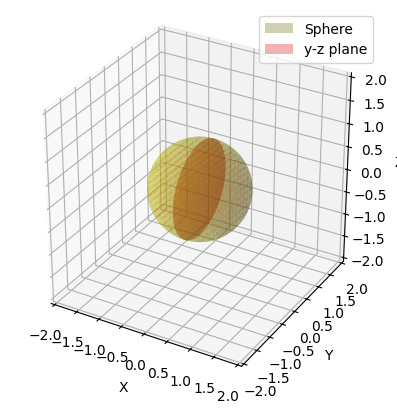

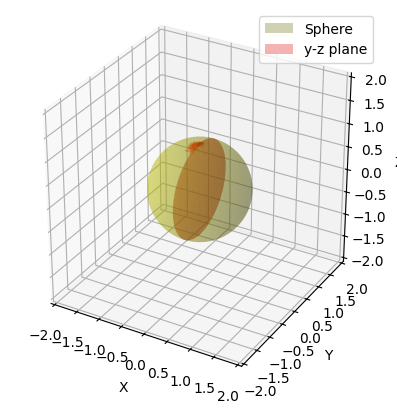

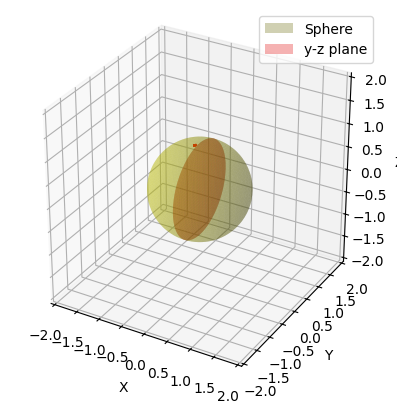

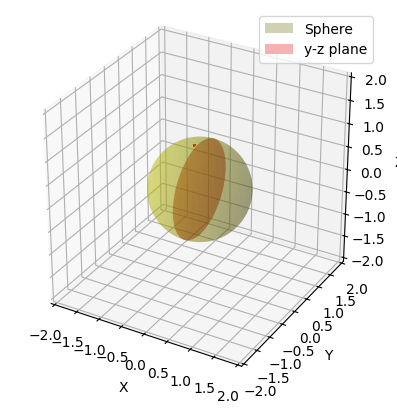

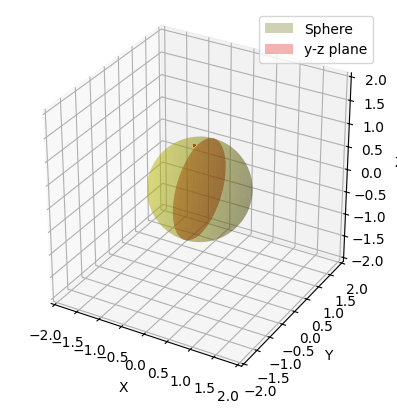

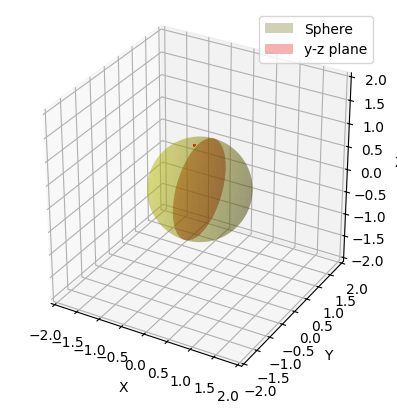

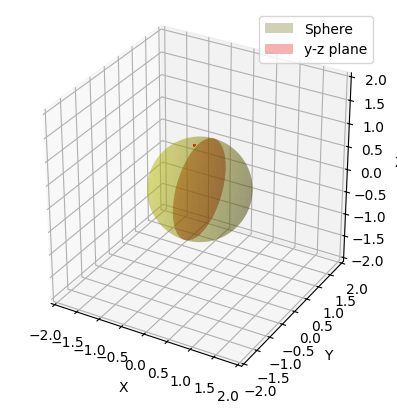

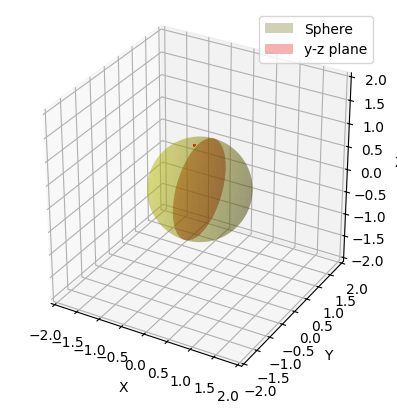

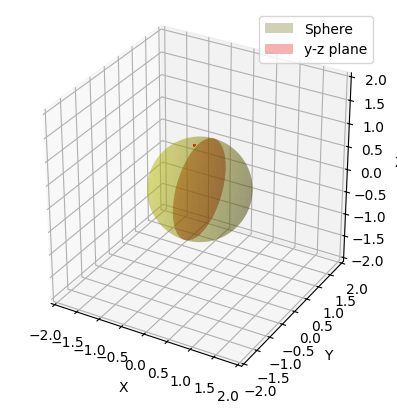

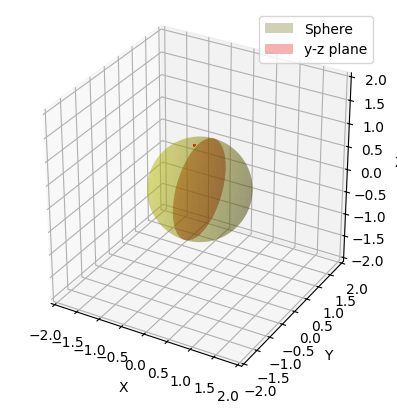

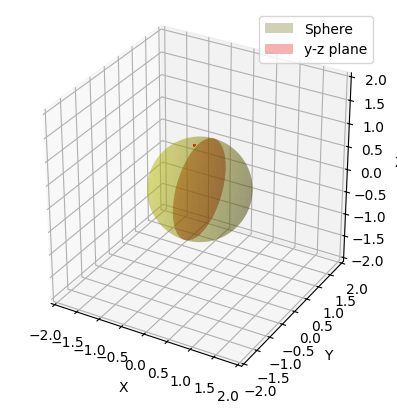

In [7]:
q1, q2, q3 = out[0], out[1], out[2]

# Create data for a sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

R0 = 1

for time in np.arange(0,1501,150):

    inside = np.sqrt(q1[:, time]**2 + q2[:, time]**2 + q3[:, time]**2) <= R0
    outside = np.sqrt(q1[:, time]**2 + q2[:, time]**2 + q3[:, time]**2) > R0

    # inside_particles = out[inside, :, time]
    # check = np.sqrt(out[inside, 0, time]**2 + out[inside, 1, time]**2 + out[inside, 2, time]**2)
    # avg_loc = np.mean(inside_particles, axis=0)[:3]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(q1[inside, time], q2[inside, time], q3[inside, time], s=0.1, c='r', marker='.', alpha=0.6)
    # ax.scatter(out[outside, 0, time], out[outside, 1, time], out[outside, 2, time], s=0.1, c='b', marker='.')

    ax.plot_surface(x, y, z, color='y', alpha=0.3, label='Sphere')
    # Plot the y-z plane
    x_plane = np.zeros_like(y)  # Constant x values
    ax.plot_surface(x_plane, y, z, color='r', alpha=0.3, label='y-z plane')


    # ax.text(-4, 0, 2, 'aggregation at \n ({:.2f}, {:.2f}, {:.2f})'.format(avg_loc[0], avg_loc[1], avg_loc[2]))
    ax.legend()
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([3,3,3])
    
    # Set perspective projection
    ax.set_proj_type('persp')
    
    # plt.savefig('3Daggregation_{}.png'.format(time), dpi=300)
    plt.show()
    # plt.close()
    


In [8]:
test = np.sqrt(np.mean(q1[inside, -1]**2 + q2[inside, -1] **2 + (q3[inside, -1])**2))
test =np.mean(q1[inside, -1]), np.mean(q2[inside, -1]) ,np.mean(q3[inside, -1]) 
test

(-0.11841673368771019, -1.7431068434610504e-09, 0.9182903459083489)